In [1]:
%matplotlib notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import os

from load_data import *
from transformation import *
import cv2
from pr2_utils import *
from map_utils import *
from motion_utils import *
from particle import *

In [2]:
# get data
data_path = "../data/"
data_version = 21
encoder_file_name = f"Encoders{data_version}.npz"
lidar_file_name = f"Hokuyo{data_version}.npz"
imu_file_name = f"Imu{data_version}.npz"
camear_file_name = f"Kinect{data_version}.npz"

data = getData(data_path, encoder_file_name, lidar_file_name, imu_file_name, camear_file_name)

In [13]:
# plot map with first laser scan
pose = { 'x': 0.0, 'y': 0.0, 'theta': 0.0 }
xlim = (-30,30)
ylim = (-30,30)
Map = OccupancyMap(xlim=xlim, ylim=ylim, res=0.2)
Map.mapping(data['lidar'], 0, pose)

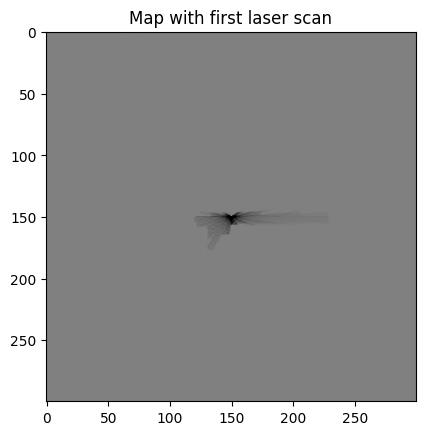

In [14]:
plt.imshow(Map.grid, cmap='gray',vmin=-100, vmax=100)
plt.title("Map with first laser scan")
plt.savefig(f"../fig/first_{data_version}")

In [15]:
# sync data
data_aligned = alignDataWithTime(data)

In [16]:
# dead-reckoning
robot_pose = getOdometry(data_aligned)

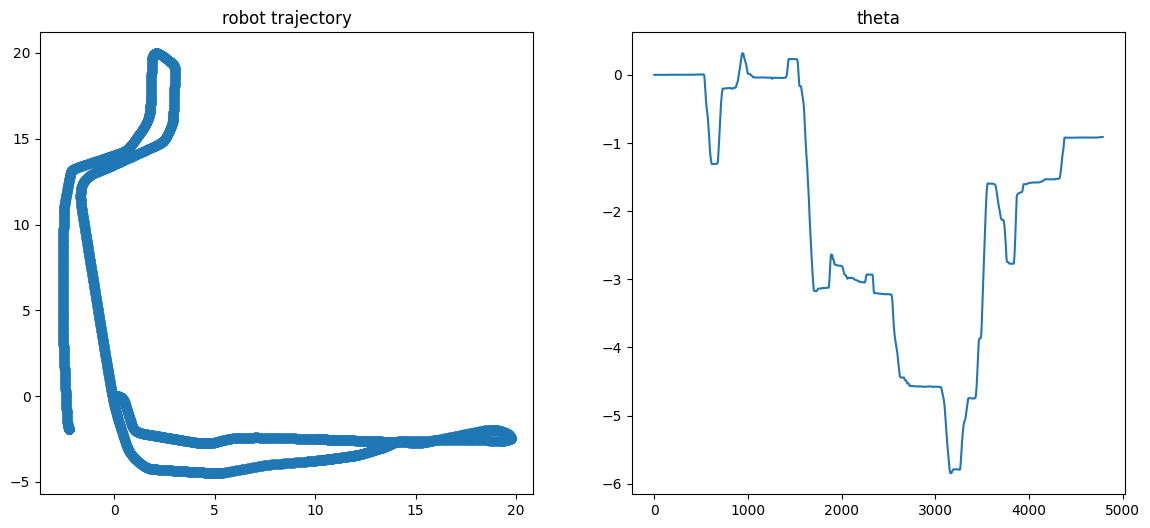

In [17]:
# plot trajectory
traj = robot_pose[:,:2]
fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
plt.scatter(traj[:,0], traj[:,1])
plt.title("robot trajectory")

ax2 = fig.add_subplot(122)
plt.plot(robot_pose[:,2])
plt.title("theta")
plt.savefig(f"../fig/traj_{data_version}")

In [19]:
# init particles
P = Particle(num=64)
step_size = 10
trajectory = np.empty(shape=(1,2))
var_scale = np.array([0.001, 0.001, 0.01*np.pi/180])

In [20]:
# start particle filter slam
lidar_data = data['lidar']
for i in range(0, len(lidar_data['lidar_ranges']), step_size):
    if i % 100 == 0: 
        print(f"Step {i}")
    
    # Predict
    delta_pose = getRelativeMotion(robot_pose, i, step_size)
    P.states = motionModelPrediction(P.states, delta_pose, var_scale)

    # Update
    best_particle = measurement_model_update(Map, P, lidar_data, i)
    trajectory = np.vstack((trajectory, [int(best_particle[0] / Map.res) + Map.xsize // 2, int(best_particle[1] / Map.res) + Map.ysize // 2]))

    # Mapping
    best_pose = { 'x': best_particle[0], 'y': best_particle[1], 'theta': best_particle[2] }
    Map.mapping(lidar_data, i, best_pose)

    # Resample
    N_eff = 1 / np.sum(P.weight ** 2)
    if N_eff < 0.3 * P.num:
        print("Resampling...")
        P.resampling()
        

Step 0
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Step 1100
Step 1200
Step 1300
Step 1400
Step 1500
Step 1600
Step 1700
Step 1800
Step 1900
Step 2000
Step 2100
Step 2200
Step 2300
Step 2400
Step 2500
Step 2600
Step 2700
Step 2800
Step 2900
Step 3000
Step 3100
Step 3200
Step 3300
Step 3400
Step 3500
Step 3600
Step 3700
Step 3800
Step 3900
Step 4000
Step 4100
Step 4200
Step 4300
Step 4400
Step 4500
Step 4600
Step 4700


Plot...


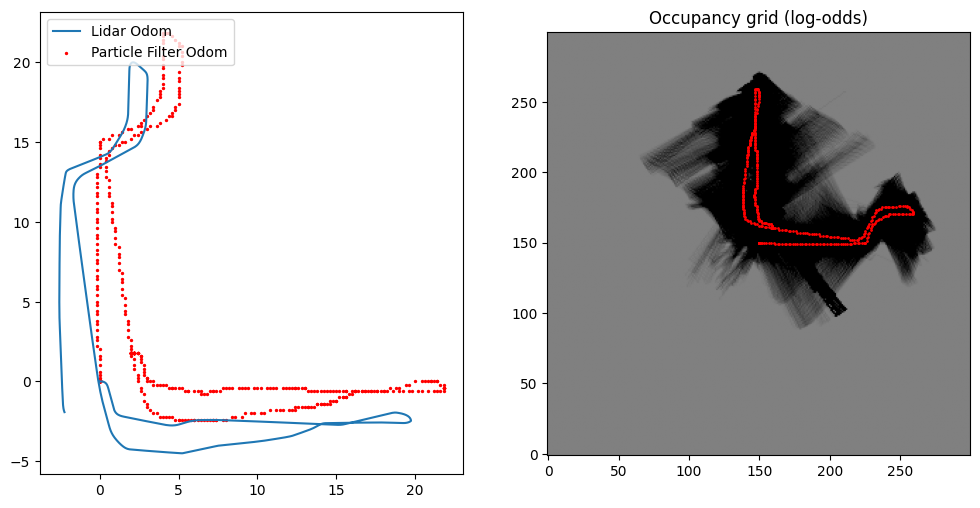

In [22]:
Map.plot(robot_pose, trajectory, f"../fig/grid_{data_version}")